# Rekt db analysis
This is a quick analysis of DefiYield's [Rekt Database](https://docs.defiyield.app/audits/rekt-database). The purpose of this analysis was to show the occurences and value of funds lost from all exploits, hacks or market-caused meltdowns. 

The first couple of views outline the all time top 10 offending categories. 
* Some categories, like `Token`, have very high exploit occurences (180/yr on average) but contribute to a very low portion of the total funds losts from exploits. 
* Others, like `Stablecoins` or `CeFi Borrowing & Lending` tend to have low occurences but the high impact at each occurence leads them to contribute the highest to the overall lost funds.

The second part of the analysis are adjacency matrices that buckets historical data into category-issue type. This enables us to see the highest contributing issue types per categories (or which categories are the most impacted by a certain type of issue). 
* In terms of occurences, the most common `Token` exploits are due to Honeypot or Rugpulls, i.e. intentional rugs from the owners of the projects. Same goes for DEX exploits.
* In terms of value of funds lost, Rugpulls and Access Control issues top the `CeFi` issue types with 13 billions USD lost. Bridges exploits tend to have hive value impacts when due to Access control issues as well.

In the last part, we show the value of funds lost over time, in absolute and relative terms. While the LUNA crash biases the relative numbers a bit, it tends to show that, as the space matures, the category of exploits tend to diversify as well.

In [1]:
import helpers.api_wrapper as DYapi
import pandas as pd

def queryAll(pageNumber):
    
    query = """
        {
            rekts(
                pageNumber:%d
                pageSize:50
                orderBy: {
                    fundsLost: desc
                }
            ){
                id
                projectName
                description
                date
                fundsLost
                fundsReturned
                chaindIds
                category
                issueType
            }
        }
    """
    
    
    return query % (pageNumber)

In [2]:
##loop through the API to collect all exploits

dataReturned = True
pageNumber = 1
exploits = []

while dataReturned:
    
    query = queryAll(pageNumber)
    data = DYapi.runQuery(query)
    
    if len(data['data']['rekts'])>0:
        #if data is returned, append to main list and increment pageNumber
        exploits.extend(data['data']['rekts'])
        pageNumber += 1
    else:
        #else end loop
        dataReturned = False
        
#load the data in a pandas data frame

df_exploits = pd.DataFrame(exploits)

# Overview

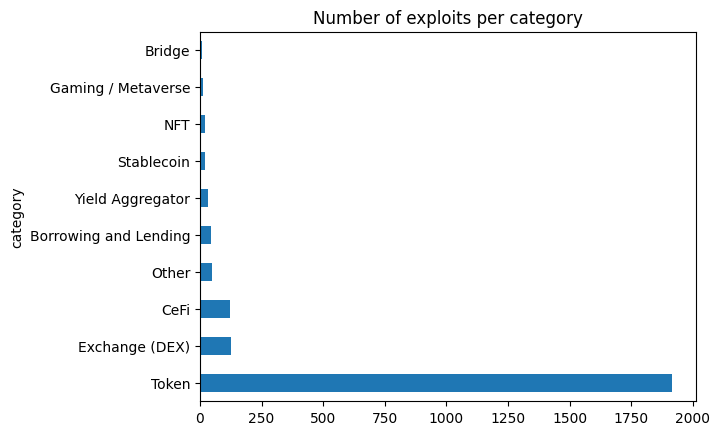

In [3]:
categoryRiskNo = df_exploits.groupby('category')['id'].count().sort_values(ascending=False).head(10).plot.barh(x='category',y='id', rot = 0, title = 'Number of exploits per category')

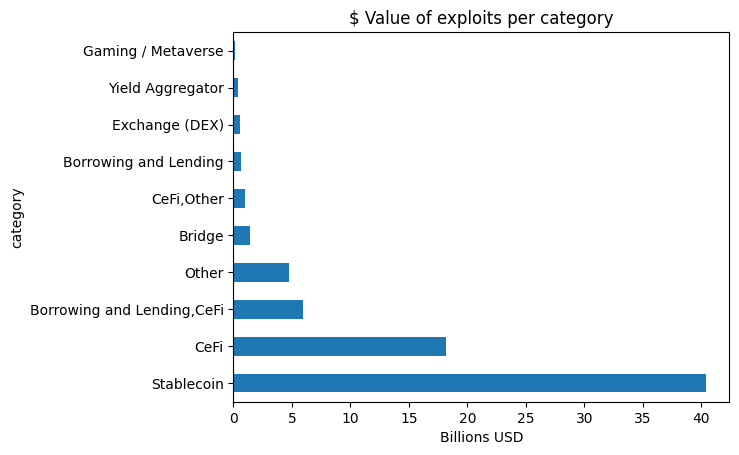

In [4]:
df_exploits['fundsLostBillions'] = df_exploits['fundsLost'].astype(float)/1E9
categoryRiskValue = df_exploits.groupby('category')['fundsLostBillions'].sum().sort_values(ascending=False).head(10).plot.barh(x='category',y='id', xlabel='Billions USD', rot = 0, title = '$ Value of exploits per category')

# Heatmap matrices
Heatmaps allow us to quickly visualize the most prominent issues within each category:
* Occurence-based: which are the category-issues combinations where the most exploits happen
* Value-based: which are the category-issues combinations where the highest value (in USD) was lost

In [5]:
## heatmaps
adjacency_matrix_occurences = pd.crosstab(df_exploits.category, df_exploits.issueType)
adjacency_matrix_usd = pd.crosstab(df_exploits.category, df_exploits.issueType, values=df_exploits.fundsLostBillions, aggfunc=sum)

## Occurence heatmap

In [6]:
adjacency_matrix_occurences.style.background_gradient(axis = None, cmap='Reds')

issueType,Abandoned,Access Control,Flash Loan Attack,Honeypot,Oracle Issue,Other,Phishing,Reentrancy,Rugpull
category,,,,,,,,,
Borrowing and Lending,0,3,6,12,4,15,0,1,6
"Borrowing and Lending,CeFi",0,0,0,0,0,2,0,0,1
"Borrowing and Lending,Exchange (DEX)",0,0,1,1,0,3,0,0,0
"Borrowing and Lending,Exchange (DEX),Stablecoin",0,0,0,0,1,0,0,0,0
"Borrowing and Lending,NFT",0,0,0,0,1,0,0,1,0
"Borrowing and Lending,Other",0,0,0,0,1,1,0,0,0
"Borrowing and Lending,Stablecoin",0,0,0,1,1,0,0,0,0
Bridge,0,3,0,0,0,7,0,0,0
"Bridge,Exchange (DEX)",0,1,0,0,0,0,0,0,0


## Value Heatmap (in USD billions)

In [7]:
adjacency_matrix_usd.fillna(0).style.background_gradient(axis = None, cmap='Reds')

issueType,Abandoned,Access Control,Flash Loan Attack,Honeypot,Oracle Issue,Other,Phishing,Reentrancy,Rugpull
category,,,,,,,,,
Borrowing and Lending,0.000000,0.107212,0.019180,0.000000,0.181760,0.282067,0.000000,0.079749,0.008476
"Borrowing and Lending,CeFi",0.000000,0.000000,0.000000,0.000000,0.000000,3.990000,0.000000,0.000000,2.000000
"Borrowing and Lending,Exchange (DEX)",0.000000,0.000000,0.130000,0.000000,0.000000,0.004072,0.000000,0.000000,0.000000
"Borrowing and Lending,Exchange (DEX),Stablecoin",0.000000,0.000000,0.000000,0.000000,0.000111,0.000000,0.000000,0.000000,0.000000
"Borrowing and Lending,NFT",0.000000,0.000000,0.000000,0.000000,0.001115,0.000000,0.000000,0.001430,0.000000
"Borrowing and Lending,Other",0.000000,0.000000,0.000000,0.000000,0.002000,0.090000,0.000000,0.000000,0.000000
"Borrowing and Lending,Stablecoin",0.000000,0.000000,0.000000,0.000000,0.035000,0.000000,0.000000,0.000000,0.000000
Bridge,0.000000,0.726166,0.000000,0.000000,0.000000,0.684739,0.000000,0.000000,0.000000
"Bridge,Exchange (DEX)",0.000000,0.000080,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Funds lost from exploits over time

<AxesSubplot: title={'center': 'Funds lost from exploits per category over time'}, xlabel='date_month'>

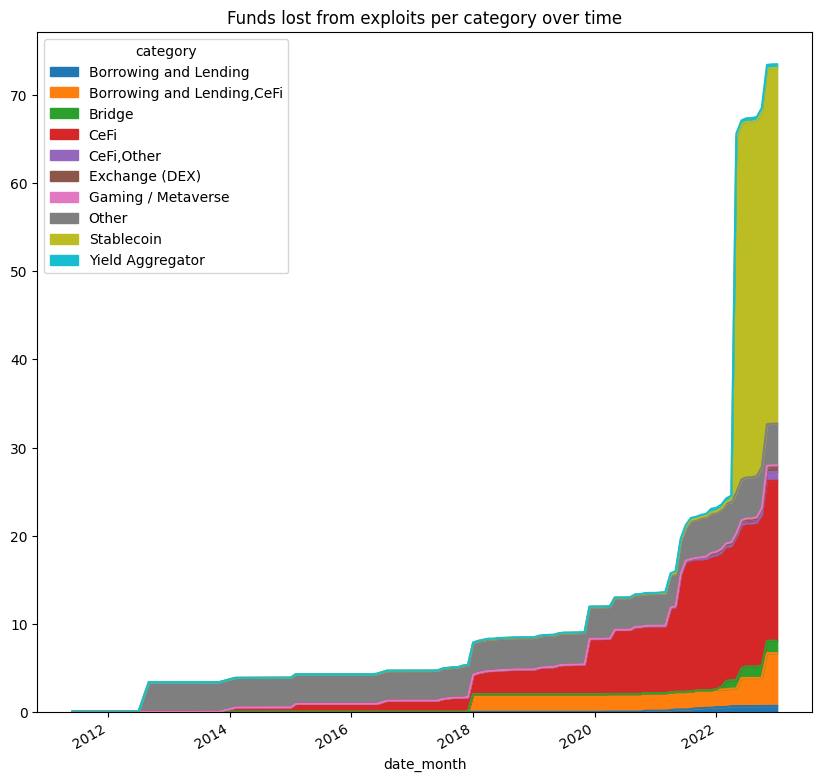

In [26]:
#Time series
df_exploits['date_month'] = pd.to_datetime(df_exploits['date']) + pd.offsets.MonthBegin(-1)

#df_exploits.groupby(['date_month','category'])['fundsLostBillions'].sum().sort_values('date_month').plot.area(x = 'date_month', y = 'fundsLostBillions', stacked = True)

timeseries_category = pd.crosstab(
    pd.merge(df_exploits,df_exploits.groupby('category')['fundsLostBillions'].sum().sort_values(ascending=False).head(10),how='inner',on='category').date_month,
    pd.merge(df_exploits,df_exploits.groupby('category')['fundsLostBillions'].sum().sort_values(ascending=False).head(10),how='inner',on='category').category,
    values=pd.merge(df_exploits,df_exploits.groupby('category')['fundsLostBillions'].sum().sort_values(ascending=False).head(10),how='inner',on='category').fundsLostBillions_x,
    aggfunc=sum
).fillna(0).cumsum()#.reset_index(level = ['category'])

timeseries_category.plot.area(stacked = True, figsize = (10,10), title = 'Funds lost from exploits per category over time')

<AxesSubplot: title={'center': 'Funds lost from exploits over time - Relative'}, xlabel='date_month'>

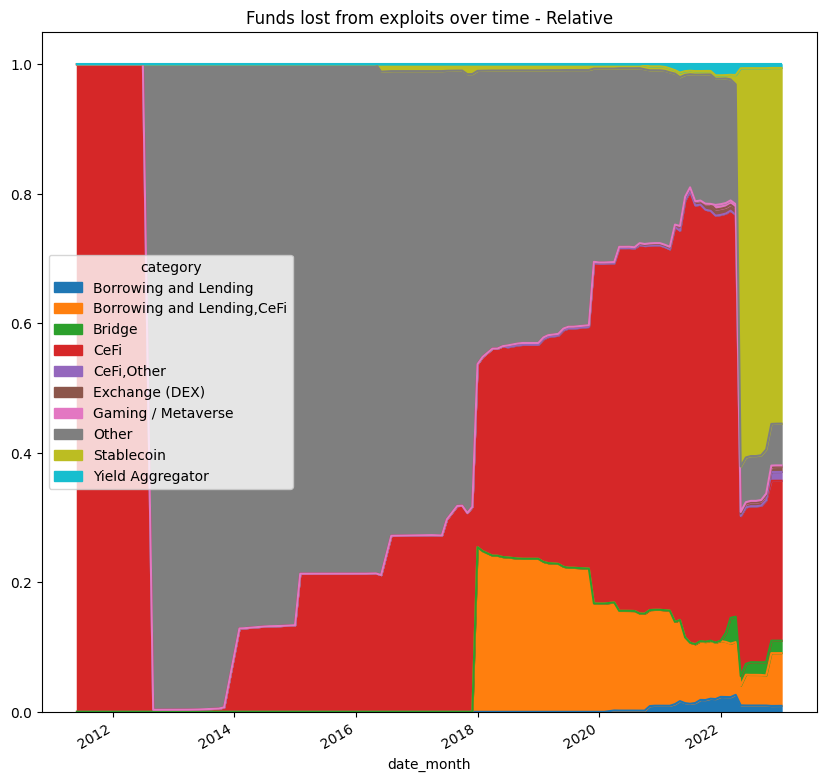

In [25]:
timeseries_category_normalized = timeseries_category.div(timeseries_category.sum(axis=1), axis=0)
timeseries_category_normalized.plot.area(stacked = True, figsize = (10,10), title= 'Funds lost from exploits over time - Relative')